In [1]:
#Libraries importation
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()
import numpy as np
import scipy
import imageio
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
#Disable training operations
K.set_learning_phase(0)

#Load pretrained InceptionV3
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

#
layer_contributions = {
    "mixed2": 0.7,
    "mixed3": 2.2,
    "mixed4": 1.2,
    "mixed5": 0.2,
}

d:\program_file\anaconda3\envs\tf_2.4\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
#Map layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

#Loss defined by adding layer contribution
loss = K.variable(0)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    #activation gets the layer output
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    #We add the l2 norm
    loss =loss + coeff * K.sum(K.square(activation[:, 2: -2:, 2: -2, :])) / scaling

In [4]:
# This is the image or dream that is stored in this tensor'
dream = model.input

#Obtains the gradient wrt to the loss
grads = tf.gradients(loss, dream)[0]

#Normalizes the gradient
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

#Create a keras function to get the value of the loss & gradients wrt to the input
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    # Returns the loss and gradient values
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_value = outs[1]
    return loss_value, grad_value

def gradient_ascent(x, iterations, steps, max_loss=None):
    #Implements gradient access for a specific number of iterations
    for i in range(iterations):
        loss_value, grad_value = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print("...Loss value at", i, ":", loss_value)
        x += step * grad_value
    return x

Processing image shapes (587, 1044)
...Loss value at 0 : 1.3315601
...Loss value at 1 : 1.6130455
...Loss value at 2 : 1.994741
...Loss value at 3 : 2.4566662
...Loss value at 4 : 2.926045
...Loss value at 5 : 3.4039557
...Loss value at 6 : 3.8671572
...Loss value at 7 : 4.3276124
...Loss value at 8 : 4.7732487
...Loss value at 9 : 5.2113605
...Loss value at 10 : 5.635623
...Loss value at 11 : 6.0462394
...Loss value at 12 : 6.4472175
...Loss value at 13 : 6.833015
...Loss value at 14 : 7.2113047
...Loss value at 15 : 7.567668
...Loss value at 16 : 7.929266
...Loss value at 17 : 8.267497
...Loss value at 18 : 8.600905
...Loss value at 19 : 8.921444
Processing image shapes (822, 1462)
...Loss value at 0 : 2.587483
...Loss value at 1 : 3.5547607
...Loss value at 2 : 4.2999024
...Loss value at 3 : 4.9445095
...Loss value at 4 : 5.5460258
...Loss value at 5 : 6.0777674
...Loss value at 6 : 6.59394
...Loss value at 7 : 7.0832872
...Loss value at 8 : 7.5359254
...Loss value at 9 : 7.970412
.

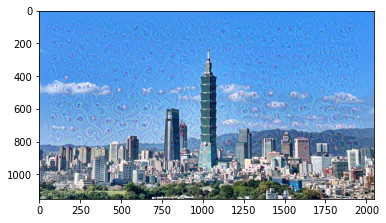

In [20]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, 
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2
    x += 0.5
    x *=255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.0

base_image_path = "Taipei_Skyline_2021.jpg"

#Load our image
img = preprocess_image(base_image_path)

#Initialize a list of tuples for our different images sizes/scales
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
#Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

#Resize the numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print("Processing image shapes", shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                         iterations=iterations,
                         steps=step,
                         max_loss=max_loss)
    
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img+= lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    #save_img(img, fname="dream_at_scale_" + str(shape) + ".png")
    
save_img(img, fname="final_dream.png")
print("DeepDreaming Complete")

#Output the art image
image_path = "final_dream.png"
img1 = tf.keras.preprocessing.image.load_img(image_path)
plt.imshow(img1)